# Initial MODIS VCI Experiment

In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
# colormaps = https://matplotlib.org/cmocean/
import cmocean
import matplotlib.pyplot as plt
import geopandas as gpd
from typing import List, Tuple, Dict, Union, Optional

import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 150

import os

# set the working directory
current_path = Path('.').resolve()
if current_path == Path('/home/tommy/ml_drought/notebooks/draft'):
    os.chdir(current_path.parents[1].as_posix())

current_path = Path('.').resolve()
assert current_path.name == "ml_drought"

%load_ext autoreload
%autoreload 2

In [2]:
from scripts.utils import get_data_path
from src.engineer import Engineer
from src.utils import get_ds_mask
from src.utils import drop_nans_and_flatten

In [3]:
data_dir = get_data_path()
EXPERIMENT = experiment = "one_month_forecast"

# Read data

In [5]:
from src.analysis import read_train_data, read_test_data, read_pred_data, temporal_r2
from scripts.analysis import (
    read_all_data, 
    read_all_available_pred_data, 
    load_nn, 
    create_all_error_metrics, 
    create_all_temporal_error_metrics, 
    create_timeseries_of_error_metrics
)

In [6]:
experiment = "one_month_forecast"
[d.name for d in (data_dir / f"models/{experiment}").iterdir()]

['ealstm',
 'rnn_0',
 'rnn_unscaled_modis',
 'previous_month_unscaled_modis',
 'previous_month',
 'rnn']

In [81]:
X_train, y_train, X_test, y_test = read_all_data(
    data_dir, static=False, experiment=experiment
)
mask = get_ds_mask(X_train["modis_vci"])
test_da = y_test[list(y_test.data_vars)[0]]

assert y_train.merge(y_test).max() < 200

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/dataarray.py:1965: PendingDeprecationWarning: dropping variables using `drop` will be deprecated; using drop_vars is encouraged.
  ds = self._to_temp_dataset().drop(labels, dim, errors=errors)


In [84]:
if False:
    from src.engineer import Engineer 
    experiment = "one_month_forecast"
    process_static = True

    engineer = Engineer(
        data_dir, experiment=experiment, process_static=process_static
    )
    all_data = engineer.engineer_class._make_dataset(static=False)
    all_data

###  Prediction

In [8]:
# read the predicted data
predictions = read_all_available_pred_data(data_dir, experiment=experiment)
predictions = {model: predictions[model] for model in ["rnn", "previous_month"]}

In [85]:
import warnings
warnings.filterwarnings('ignore')

key = "rnn"
test_da = test_da.sel(lat=predictions[key].lat)
rmse_dict, r2_dict = create_all_error_metrics(predictions, test_da)
time_rmse_dict, time_r2_dict = create_all_temporal_error_metrics(predictions, test_da)

warnings.filterwarnings('default')

In [12]:
time_r2, _ = create_timeseries_of_error_metrics(predictions, test_da)

time_r2_xr = xr.merge([time_r2["rnn"].rename("rnn"), time_r2["previous_month"].rename("previous_month")])
time_r2_xr["season"] = time_r2_xr["time.season"]

# Analysis

In [13]:
def stack_xr_to_df(ds: xr.Dataset, append_latlon: bool = False) -> pd.DataFrame:
    stacked = ds.stack(pixel=["lat", "lon"]).drop_vars("time")
    pixels_lookup = dict(enumerate(stacked["pixel"].values))
    stacked["pixel"] = np.arange(len(pixels_lookup))
    df = stacked.to_dataframe().dropna().reset_index()
    if append_latlon:
        df["latlon"] = [pixels_lookup[p] for p in df["pixel"]]

    return df, pixels_lookup


def dict_xr_to_pd(error_dict: Dict[str, xr.Dataset], stack_to_pixel: bool = True) -> Dict[str, pd.DataFrame]:
    if stack_to_pixel:
        pd_errors = {model: stack_xr_to_df(error_dict[model], append_latlon=True)[0] for model in error_dict.keys()}
    else:
        pd_errors = {model: error_dict[model].drop_vars("time").to_dataframe().reset_index() for model in error_dict.keys()}

    return pd_errors


def join_dataframes(error_dict: Dict[str, pd.DataFrame]):
    model1 = [k for k in error_dict.keys()][0]
    df1 = error_dict[model1].set_index("pixel").rename({"r2": model1}, axis=1).drop("latlon", axis=1)
    for model in np.array([k for k in error_dict.keys()])[1:]:
        df2 = error_dict[model].set_index("pixel").rename({"r2": model}, axis=1).drop("latlon", axis=1)
        df1 = df1.join(df2)
        
    return df1


r2_dict2 = dict_xr_to_pd(r2_dict)
r2_df = join_dataframes(r2_dict2)
r2_df.head()

,rnn,previous_month
pixel,,
280,0.588319,NaN
435,0.391488,0.150519
436,0.377935,0.221913
437,0.260730,-0.011386
438,0.317931,-0.069242


In [14]:
from typing import Optional, List, Tuple


def plot_cdf(error_data: pd.DataFrame, metric: str, clip: Optional[Tuple] = None, ax = None, kwargs_dict: Dict = {}):
    colors = sns.color_palette()
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 3))

    for ix, model in enumerate(error_data.columns):
        sns.kdeplot(
            error_data[model].dropna(),
            cumulative=True,
            legend=False, ax=ax,
            label=f"{model}: {error_data[model].median():.2f}",
            color=colors[ix],
            **kwargs_dict
        )

        ax.axvline(error_data[model].dropna().median(), ls="--", color=colors[ix], **kwargs_dict)

    ax.set_xlim(clip)
    ax.set_xlabel(metric)
    ax.set_ylabel("Cumulative density")
    title = f"Cumuluative Density Function of {metric} Scores"
    ax.set_title(title)
    sns.despine()
    plt.legend()
    
    return ax

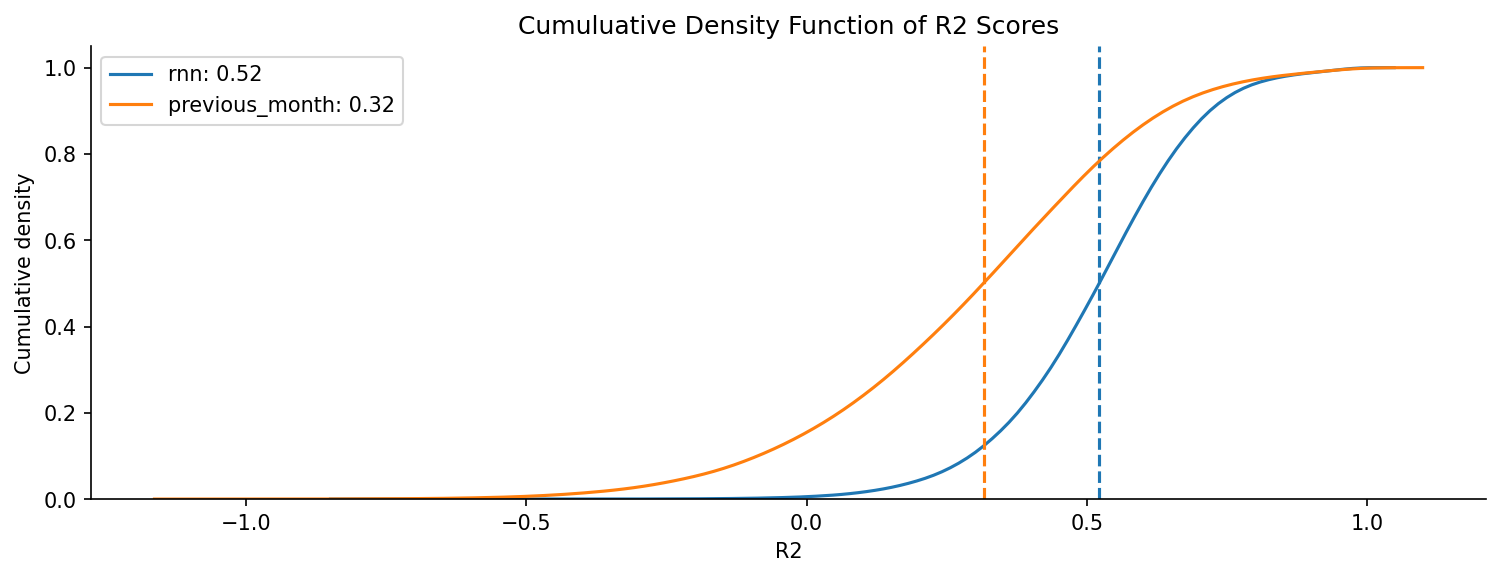

In [39]:
f, ax = plt.subplots(figsize=(12, 4))
plot_cdf(r2_df, metric="R2", ax=ax)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


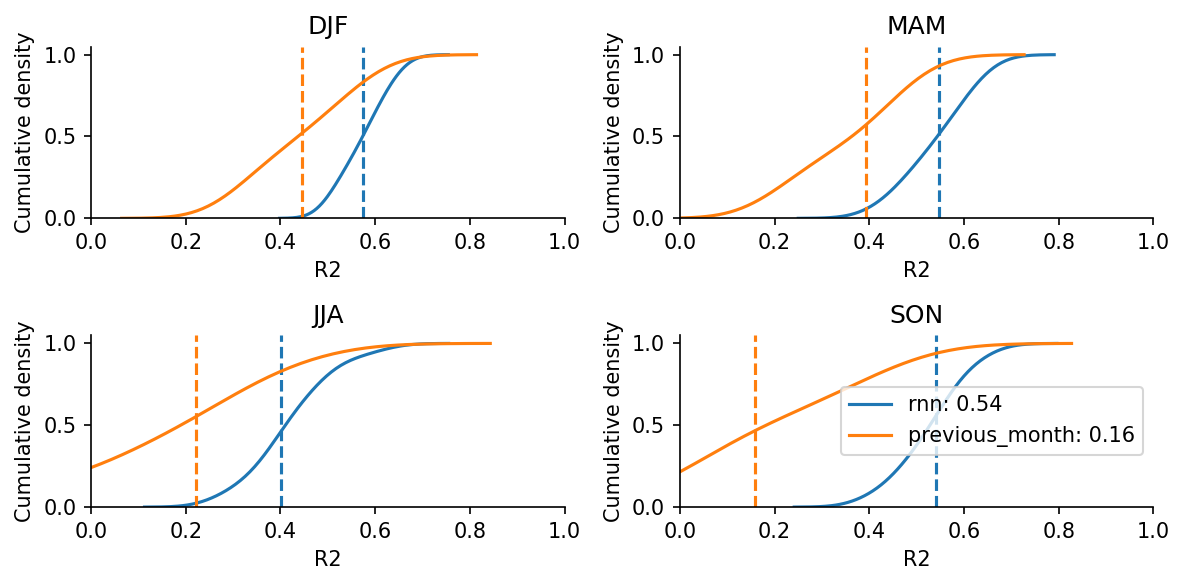

In [40]:
df_t = time_r2_xr.to_dataframe()

f, axs = plt.subplots(2, 2, figsize=(4*2, 2*2))
for ix, season in enumerate(df_t.season.unique()):
    ax = axs[np.unravel_index(ix, (2, 2))]
    d = df_t.loc[df_t.season == season].drop("season", axis=1)
    plot_cdf(error_data=d, metric=f"R2", ax=ax);
    ax.set_title(f"{season}")
    ax.set_xlim(0, 1)
    
plt.tight_layout()

## geospatial analysis

In [17]:
from scripts.analysis import create_mean_pixel_errors_gdf as create_metric_gdf

l1_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm1.shp")
l2_gdf = gpd.read_file(data_dir / "raw/boundaries/india/IND_adm2.shp")

l1_mask = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/state_l1_india.nc")
l2_mask = xr.open_dataset(data_dir / "analysis/boundaries_preprocessed/district_l2_india.nc")

l1_lookup = dict(zip(
    [int(k.lstrip().rstrip()) for k in l1_mask.attrs["keys"].split(',')], 
    [k.lstrip().rstrip() for k in l1_mask.attrs["values"].split(',')]
))
l2_lookup = dict(zip(
    [int(k.lstrip().rstrip()) for k in l2_mask.attrs["keys"].split(',')], 
    [k.lstrip().rstrip() for k in l2_mask.attrs["values"].split(',')]
))

In [18]:
import warnings
warnings.filterwarnings(action='ignore')

## -- Level 1 --
l1_rmse_gdf = create_metric_gdf(
    metric_dict=rmse_dict,
    region_gdf=l1_gdf,
    gdf_name_col="NAME_1",
    region_mask=l1_mask,
)

l1_r2_gdf = create_metric_gdf(
    metric_dict=r2_dict,
    region_gdf=l1_gdf,
    gdf_name_col="NAME_1",
    region_mask=l1_mask,
)


## -- Level 2 --
l2_rmse_gdf = create_metric_gdf(
    metric_dict=rmse_dict,
    region_gdf=l2_gdf,
    gdf_name_col="NAME_2",
    region_mask=l2_mask,
)

l2_r2_gdf = create_metric_gdf(
    metric_dict=r2_dict,
    region_gdf=l2_gdf,
    gdf_name_col="NAME_2",
    region_mask=l2_mask,
)

warnings.filterwarnings(action='default')

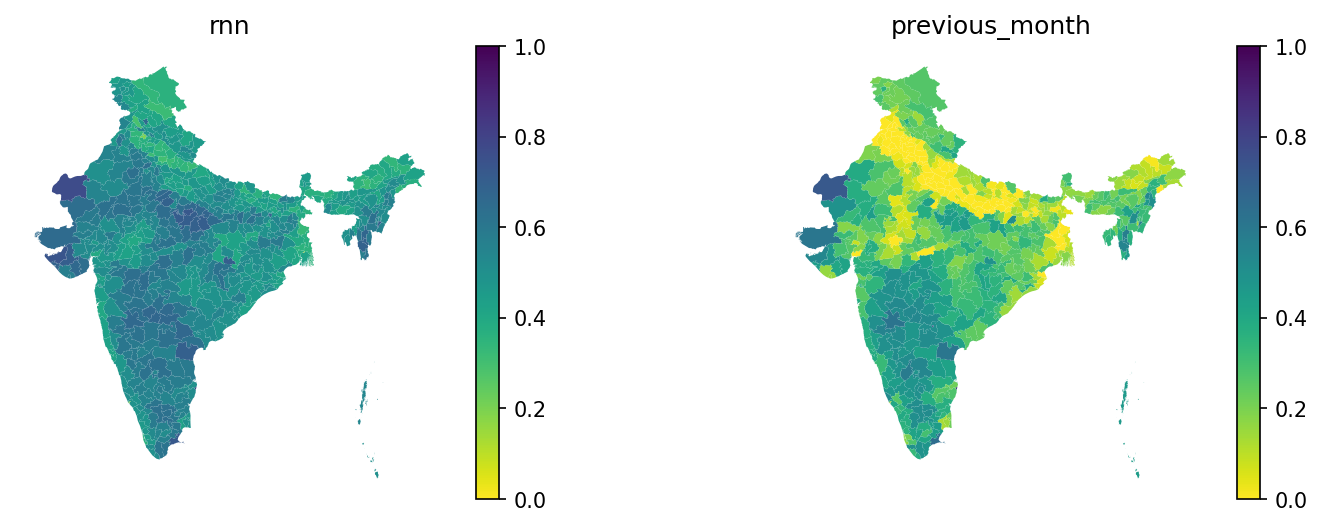

In [19]:
kwargs = {"vmin": 0, "vmax": 1, "cmap": "viridis_r"}

fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))
for i, model in enumerate([c for c in l2_r2_gdf.columns if c not in ["region_name", "geometry", "index"]]):
    ax = axs[i]
    l2_r2_gdf.plot(model, legend=True, ax=ax, **kwargs)
    ax.set_title(model)
    
    ax.axis('off')

# Calculate $\Delta$Performance

In [119]:
def delta_performance(
    error_dict: Dict[str, xr.DataArray], reference_model: str = "previous_month",
    metric: str = "r2"
):  
    delta_performance = {}
    for model in [m for m in error_dict.keys() if m != reference_model]:
        reference_errors = error_dict[reference_model]
        pred_errors = error_dict[model]
        if metric == "r2":
            pred_errors = pred_errors.where(pred_errors > -10)
        delta_performance[model] = (pred_errors - reference_errors).rename(f"{model}")
    
    return delta_performance

<>:6: DeprecationWarning: invalid escape sequence \D
<>:6: DeprecationWarning: invalid escape sequence \D
<ipython-input-396-926c703f6f3d>:6: DeprecationWarning: invalid escape sequence \D
  ax.set_title("$\Delta$R2 [$R2_{LSTM}$ - $R2_{persistence}$]");


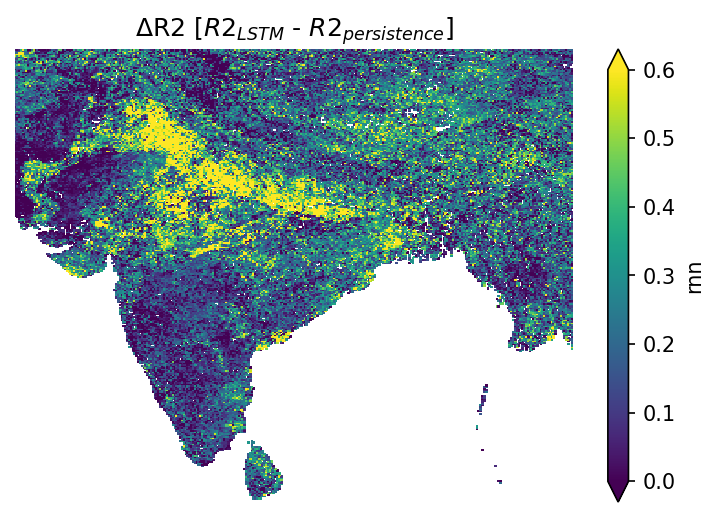

In [396]:
delta_r2 = delta_performance(r2_dict, reference_model="previous_month")
delta_time_r2 = delta_performance(time_r2_dict, reference_model="previous_month")
delta_r2["rnn"].plot(vmin=0, vmax=0.6)
ax = plt.gca()
ax.axis('off')
ax.set_title("$\Delta$R2 [$R2_{LSTM}$ - $R2_{persistence}$]");

In [45]:
delta_r2_t = delta_performance(time_r2, reference_model="previous_month")
climatology = y_train.merge(y_test).groupby("time.month").mean(dim=["lat", "lon"])

In [205]:
# delta_time_r2["rnn"]
X = []
y = []
for mth_ix in np.arange(12):
    latlons = delta_time_r2["rnn"].values[mth_ix]
    latlons = latlons.flatten()
    X.extend(latlons)
    y.extend([mth_ix + 1 for _ in range(len(latlons))])

X = np.array(X)
y = np.array(y)
nonnan = (np.isfinite(X) & np.isfinite(y))
X, y = X[nonnan], y[nonnan]

<>:66: DeprecationWarning: invalid escape sequence \D
<>:69: DeprecationWarning: invalid escape sequence \D
<>:66: DeprecationWarning: invalid escape sequence \D
<>:69: DeprecationWarning: invalid escape sequence \D
<ipython-input-374-23a572d8903d>:66: DeprecationWarning: invalid escape sequence \D
  ax.set_ylabel("$\Delta$R2")
<ipython-input-374-23a572d8903d>:69: DeprecationWarning: invalid escape sequence \D
  ax.set_title("$\Delta$R2 each month")


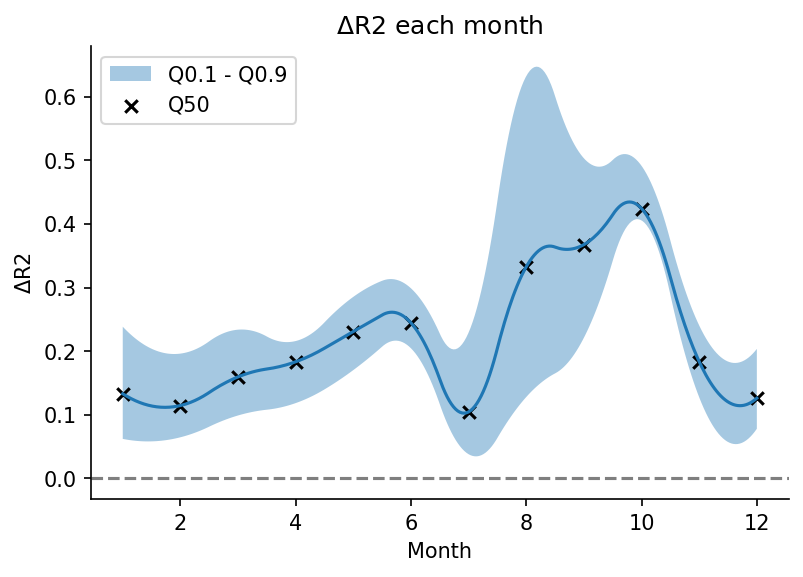

In [374]:
use_spatial_temporal = True    # delta_time_r2["rnn"] -> (time, lat, lon)
use_spatial_temporal = False   # delta_time_r2["rnn"] -> (time)


import calendar
from statsmodels.nonparametric.smoothers_lowess import lowess

# LOWESS
select = np.random.choice(np.arange(len(X)), 10000)
lowX, lowy = lowess(X[select], y[select]).T

# SPLINE (always runs through all points ...)
def smoothing_spline(X: np.ndarray, points: np.ndarray) -> Tuple[np.ndarray]:
    from scipy.interpolate import make_interp_spline, BSpline

    # 300 represents number of points to make between T.min and T.max
    xnew = np.linspace(X.min(), X.max(), 300) 

    spl: BSpline = make_interp_spline(X, points, k=2)  # type: BSpline
    y = spl(xnew)
    return xnew, y


# summary data
if use_spatial_temporal:
    means = delta_time_r2["rnn"].mean(dim=["lat", "lon"]).values
    stds = delta_time_r2["rnn"].std(dim=["lat", "lon"]).values
    medians = delta_time_r2["rnn"].median(dim=["lat", "lon"]).values
    q10 = delta_time_r2["rnn"].quantile(dim=["lat", "lon"], q=0.1)
    q90 = delta_time_r2["rnn"].quantile(dim=["lat", "lon"], q=0.9)
else:
    means = delta_r2_t["rnn"].groupby("time.month").mean()
    stds = delta_r2_t["rnn"].groupby("time.month").std()
    medians = delta_r2_t["rnn"].groupby("time.month").median()
    q10 = delta_r2_t["rnn"].groupby("time.month").quantile(q=0.1)
    q90 = delta_r2_t["rnn"].groupby("time.month").quantile(q=0.9)

    

time = np.arange(1, 13)

f, ax = plt.subplots()

xnew, std_smooth = smoothing_spline(time, stds)
xnew, smooth_10 = smoothing_spline(time, q10)
xnew, smooth_90 = smoothing_spline(time, q90)
xnew, med_smooth = smoothing_spline(time, medians)
xnew, mean_smooth = smoothing_spline(time, means)

# LINE 
ax.plot(xnew, med_smooth)
# ax.plot(xnew, mean_smooth)

# BOUNDS
# ax.fill_between(xnew, smooth + (0.2 * std_smooth), smooth - (0.2 * std_smooth), alpha=0.4)
ax.fill_between(xnew, smooth_10, smooth_90, alpha=0.4, label="Q0.1 - Q0.9")
# ax.fill_between(time, means + stds, means - stds, alpha=0.4)

# SCATTER
ax.scatter(time, medians, marker="x", color="k", label="Q50")
# ax.scatter(time, means, marker="x", color="k")

# make plot pretty
ax.set_xlabel("Month")
# ax.set_xticklabels([calendar.month_abbr[int(x.get_text())] for x in ax.get_xticklabels() if not np.isin(x.get_text(), ["", "0", "13", "14"])])
ax.set_ylabel("$\Delta$R2")
ax.axhline(0, ls="--", color="k", alpha=0.5)
ax.legend(loc="upper left")
ax.set_title("$\Delta$R2 each month")


sns.despine()

# Comparison of Obs. Predicted

In [287]:
def find_nearest(da, value):
    idx = abs(da - value).argmin()
    lat_idx, lon_idx = np.unravel_index(idx, da.shape)
    return da.isel(lat=lat_idx, lon=lon_idx)

In [294]:
median_r2 = r2_dict["rnn"].where(r2_dict["rnn"] == r2_dict["rnn"].median(), drop=True).drop("time")
q10_r2 = find_nearest(r2_dict["rnn"], r2_dict["rnn"].quantile(q=0.1)).drop("time")
q90_r2 = find_nearest(r2_dict["rnn"], r2_dict["rnn"].quantile(q=0.9)).drop("time")

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/dataarray.py:1965: PendingDeprecationWarning: dropping variables using `drop` will be deprecated; using drop_vars is encouraged.
  ds = self._to_temp_dataset().drop(labels, dim, errors=errors)


Text(0.5, 1.0, 'Median Pixel R2: 0.52')

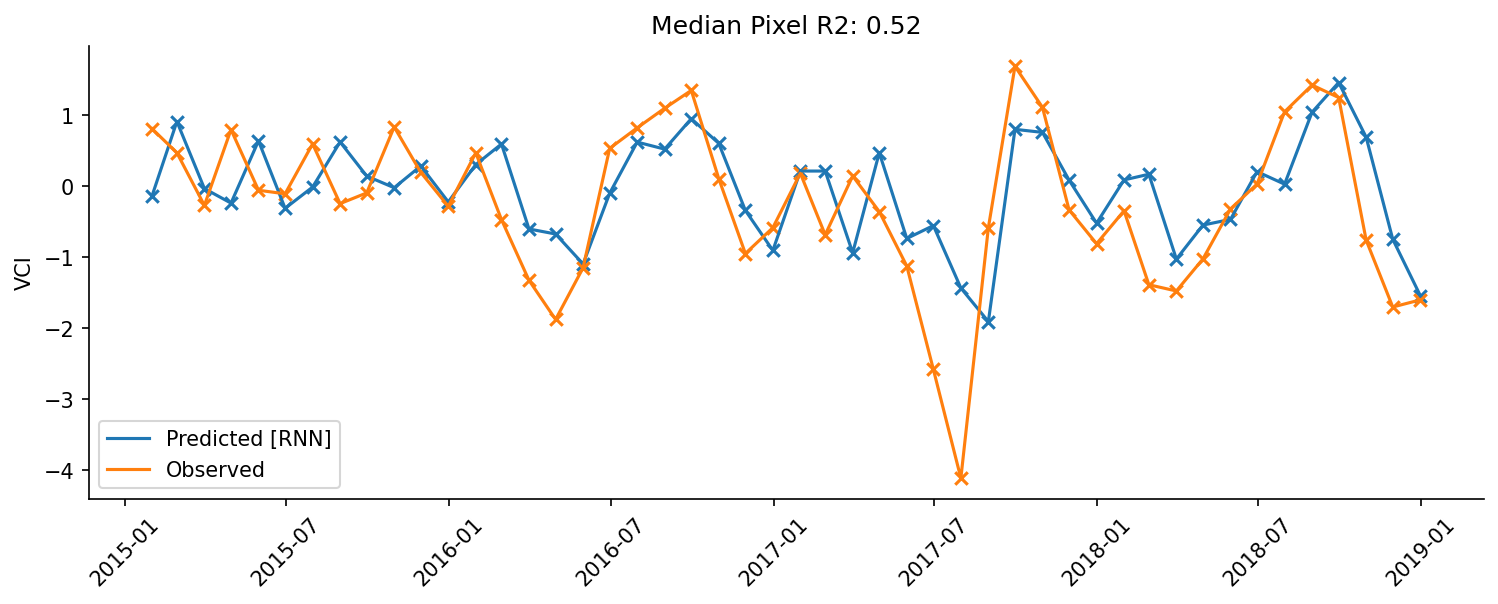

In [378]:
def plot_obs_predicted_timeseries(lat: float, lon: float, ax: Optional = None):
    preds = predictions["rnn"].sel(lat=lat, lon=lon)
    obs = test_da.sel(lat=lat, lon=lon)

    times = preds.time.values
    p = preds.values.flatten()
    o = obs.values.flatten()
    
    # xnew, pred_smooth = smoothing_spline(np.arange(len(times)), p)
    # xnew, obs_smooth = smoothing_spline(np.arange(len(times)), o)
    
    if ax is None:
        f, ax = plt.subplots(figsize=(12, 4))
        
    ax.scatter(times, p, marker="x")
    ax.plot(times, p, label="Predicted [RNN]")
    # ax.plot(xnew, pred_smooth, label="Predicted [RNN]")
    ax.scatter(times, o, marker="x")
    ax.plot(times, o, label="Observed")
    # ax.plot(xnew, obs_smooth, label="Observed")

    ax.xaxis.set_tick_params(rotation=45)
    ax.set_title(f"Pixel R2: {float(r2_dict['rnn'].sel(lat=lat, lon=lon).values.flatten()):.2f}")
    ax.set_ylabel("VCI")

    ax.legend()
    sns.despine()
    return ax

ax = plot_obs_predicted_timeseries(median_r2.lat, median_r2.lon)
ax.set_title("Median " + ax.get_title())

Text(0.5, 1.0, '10th Percentile Pixel R2: 0.29')

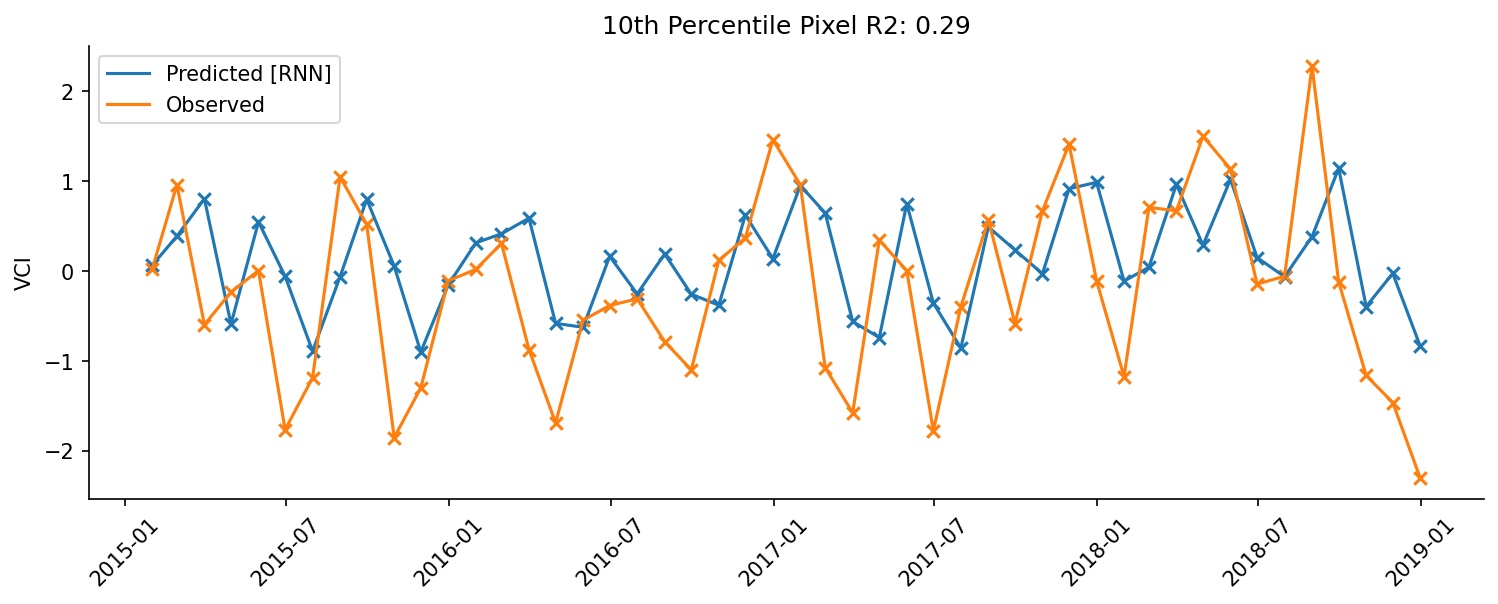

In [333]:
ax = plot_obs_predicted_timeseries(q10_r2.lat, q10_r2.lon)
ax.set_title("10th Percentile " + ax.get_title())

Text(0.5, 1.0, '90th Percentile Pixel R2: 0.72')

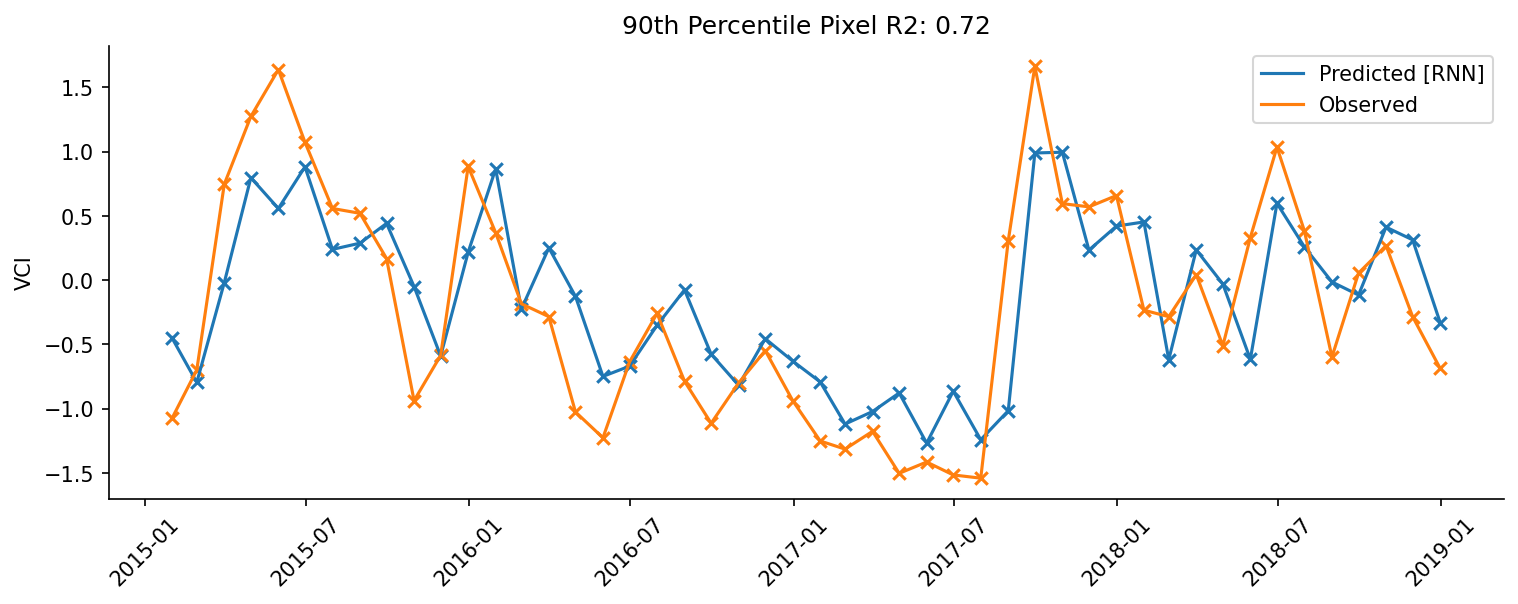

In [335]:
ax = plot_obs_predicted_timeseries(q90_r2.lat, q90_r2.lon)
ax.set_title("90th Percentile " + ax.get_title())

# Geospatial Distribution of Quantiles

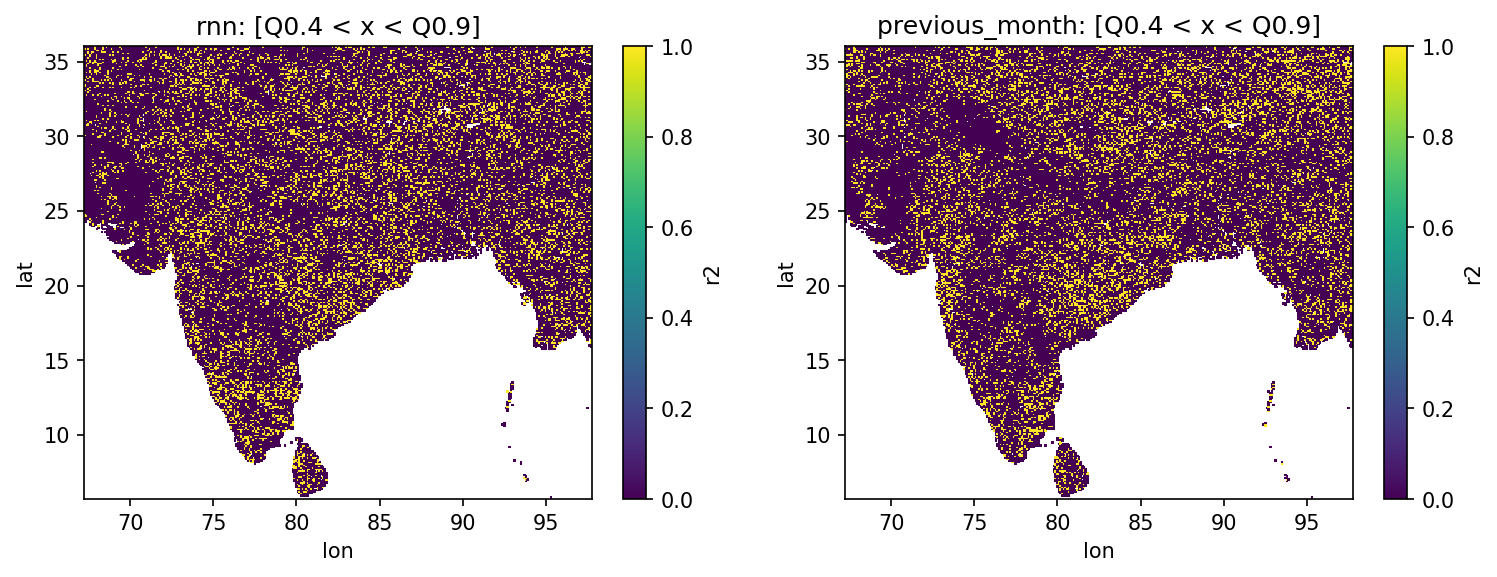

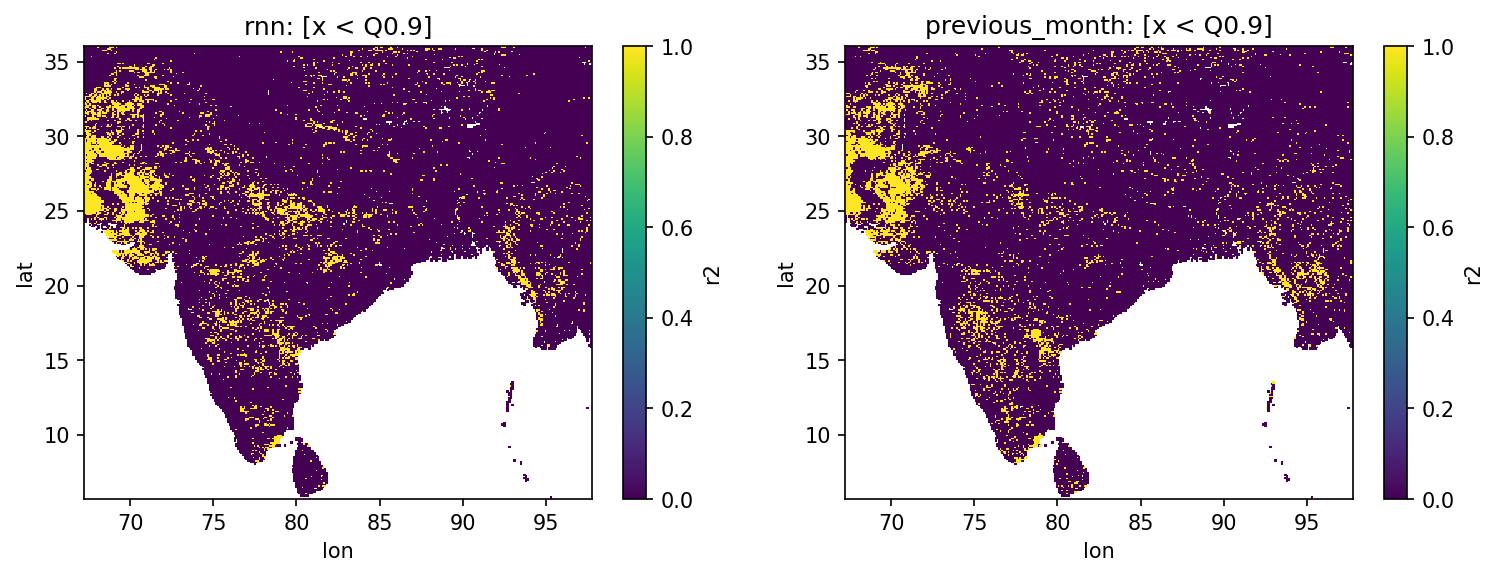

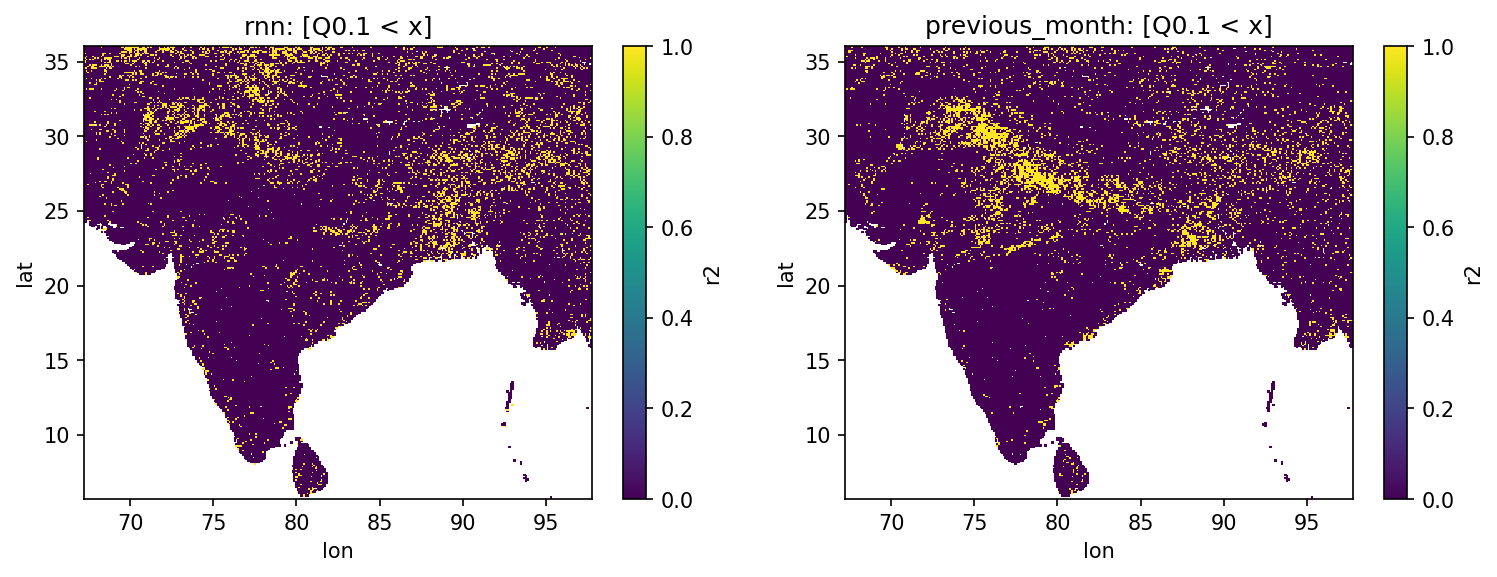

In [392]:
def get_quantile_maps_preds(
    r2_dict: Dict[str, xr.Dataset], 
    quantile_min: Optional[float] = None, 
    quantile_max: Optional[float] = None,
) -> Dict[str, xr.Dataset]:
    quantile_maps = {}
    for model in r2_dict.keys():
        if (quantile_min is not None):
            r2_low = (r2_dict[model].quantile(q=quantile_min))
        if (quantile_max is not None):
            r2_upp = (r2_dict[model].quantile(q=quantile_max))

        if (quantile_min is not None) and (quantile_max is not None):
            q_map = ((r2_low < r2_dict[model]) & (r2_dict[model] < r2_upp)).where(~mask)
        elif (quantile_min is not None):
            q_map = ((r2_low > r2_dict[model])).where(~mask)
        elif (quantile_max is not None):
            q_map = ((r2_upp < r2_dict[model])).where(~mask)
        
        quantile_maps[model] = q_map
    return quantile_maps

quantile_maps = get_quantile_maps_preds(r2_dict, 0.4, 0.6)
r2_90 = get_quantile_maps_preds(r2_dict, None, 0.9)
r2_10 = get_quantile_maps_preds(r2_dict, 0.1, None)

f, axs = plt.subplots(1, 2, figsize=(12, 4))
for ix, model in enumerate(quantile_maps.keys()):
    ax = axs[ix]
    quantile_maps[model].plot(ax=ax)
    ax.set_title(f"{model}: [Q0.4 < x < Q0.9]")
    
f, axs = plt.subplots(1, 2, figsize=(12, 4))
for ix, model in enumerate(r2_90.keys()):
    ax = axs[ix]
    r2_90[model].plot(ax=ax)
    ax.set_title(f"{model}: [x < Q0.9]")
    
f, axs = plt.subplots(1, 2, figsize=(12, 4))
for ix, model in enumerate(r2_10.keys()):
    ax = axs[ix]
    r2_10[model].plot(ax=ax)
    ax.set_title(f"{model}: [Q0.1 < x]")

# Marginalia

Text(0.5, 1.0, 'R2 Values [q0.4=0.48 < x < q0.6=0.56]')

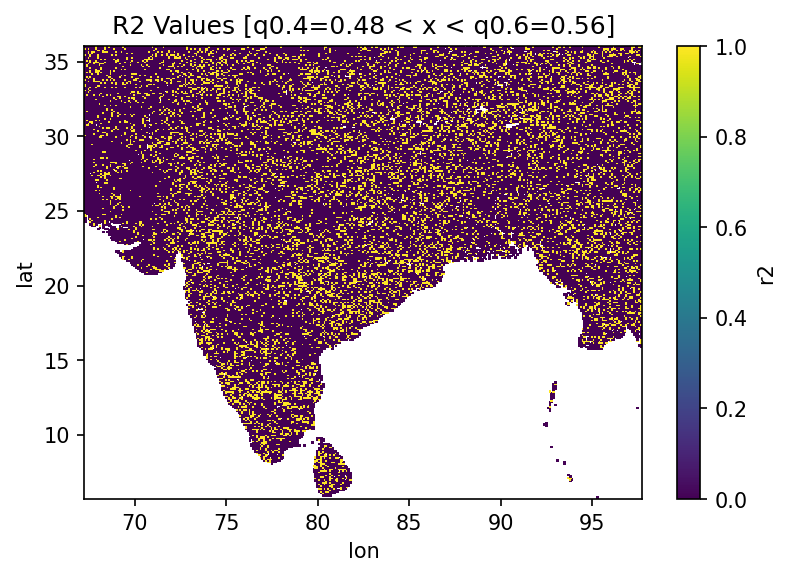

In [364]:
r2_40 = (r2_dict["rnn"].quantile(q=0.4))
r2_60 = (r2_dict["rnn"].quantile(q=0.6))
middling = ((r2_40 < r2_dict["rnn"]) & (r2_dict["rnn"] < r2_60)).where(~mask)

middling.plot()
ax.set_title(f"R2 Values [q0.4={float(r2_40.values):.2f} < x < q0.6={float(r2_60.values):.2f}]")

Text(0.5, 1.0, 'R2 Values [x > q0.9 0.72]')

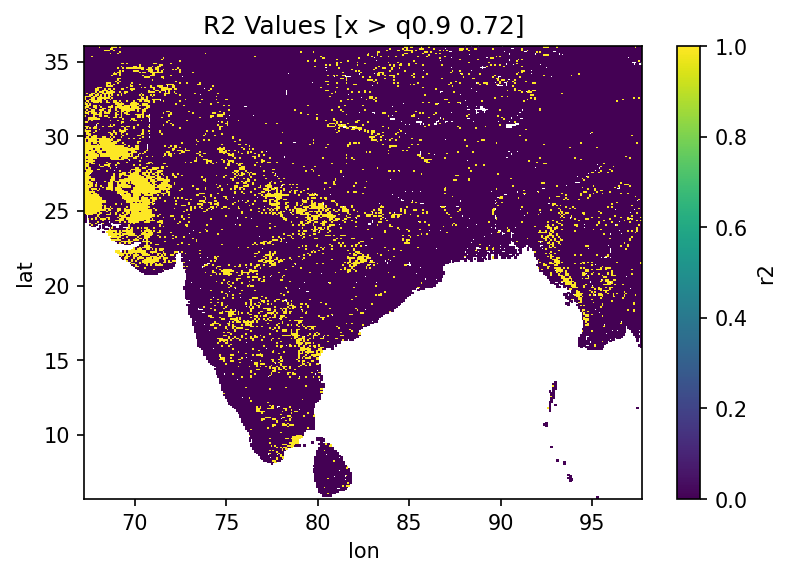

In [363]:
r2_90 = (r2_dict["rnn"].quantile(q=0.9))
middling = ((r2_90 < r2_dict["rnn"])).where(~mask)
middling.plot()
ax = plt.gca()
ax.set_title(f"R2 Values [x > q0.9={float(r2_90.values):.2f}]")

Text(0.5, 1.0, 'R2 Values [x < q0.1=0.29]')

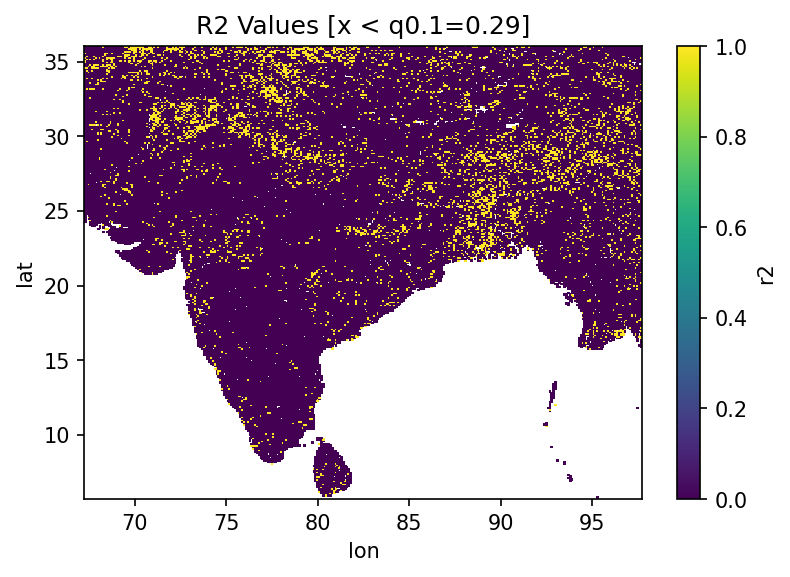

In [368]:
r2_10 = (r2_dict["rnn"].quantile(q=0.1))
middling = ((r2_10 > r2_dict["rnn"])).where(~mask)
middling.plot()
ax = plt.gca()
ax.set_title(f"R2 Values [x < q0.1={float(r2_10.values):.2f}]")